# Preprocessing, Calendar Features and Windowing

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/giulatona/iecon2025_tutorial/blob/main/notebooks/02_preprocessing_windowing_features.ipynb)

This notebook demonstrates preprocessing techniques for time series forecasting:

- **Data Preprocessing**: Cleaning, normalization, and scaling
- **Calendar Features**: Adding temporal features (to be used as exogenous features)
- **Windowing Techniques**: Creating sliding windows for sequence modeling

**Dataset**: UCI Individual Household Electric Power Consumption  
**Goal**: Prepare data for machine learning forecasting models

## Setup and Data Loading

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

### Dataset Download
The following cell downloads the dataset if not available locally. This cell is hidden by default to keep the notebook clean.

In [2]:
# Download data if not available locally
import os
import urllib.request
import zipfile

# Check if running in Google Colab
in_colab = 'google.colab' in str(get_ipython())

if in_colab:
    print("Running in Google Colab - downloading dataset...")
    !wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
    !unzip -q household_power_consumption.zip
    data_file = 'household_power_consumption.txt'
else:
    print("Running locally...")
    data_file = 'data/household_power_consumption.txt'
    
    # Create data directory if it doesn't exist
    os.makedirs('data', exist_ok=True)
    
    # Download dataset if it doesn't exist locally
    if not os.path.exists(data_file):
        print("Dataset not found locally. Downloading...")
        url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
        zip_file = 'data/household_power_consumption.zip'
        
        # Download the zip file
        urllib.request.urlretrieve(url, zip_file)
        print("Download completed. Extracting...")
        
        # Extract the zip file
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall('data/')
        
        print("Extraction completed.")
    else:
        print("Dataset found locally.")

print(f"Using data file: {data_file}")

Running locally...
Dataset found locally.
Using data file: data/household_power_consumption.txt


In [3]:
# Load and perform initial preprocessing
print("Loading dataset...")
df = pd.read_csv(data_file, sep=';', low_memory=False)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].iloc[0]} to {df['Date'].iloc[-1]}")
df.head()

Loading dataset...
Dataset shape: (2075259, 9)
Date range: 16/12/2006 to 26/11/2010
Dataset shape: (2075259, 9)
Date range: 16/12/2006 to 26/11/2010


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


## Data Preprocessing Pipeline

### 1. Basic Data Cleaning

In [4]:
def clean_data(df):
    """
    Clean the household power consumption dataset.
    
    Parameters:
    df (pd.DataFrame): Raw dataset
    
    Returns:
    pd.DataFrame: Cleaned dataset with datetime index
    """
    df_clean = df.copy()
    
    # Combine Date and Time columns
    df_clean['DateTime'] = pd.to_datetime(df_clean['Date'] + ' ' + df_clean['Time'], 
                                         format='%d/%m/%Y %H:%M:%S')
    
    # Replace '?' with NaN and convert to numeric
    numeric_columns = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
                      'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
    
    for col in numeric_columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # Set DateTime as index
    df_clean.set_index('DateTime', inplace=True)
    
    # Drop original Date and Time columns
    df_clean.drop(['Date', 'Time'], axis=1, inplace=True)
    
    return df_clean

# Apply cleaning
df_clean = clean_data(df)

### 1.1. Data Downsampling

The original dataset has 1-minute resolution, which results in a very large dataset. For this tutorial, we'll downsample to 15-minute intervals to reduce computational complexity while preserving the essential patterns.

In [5]:
def downsample_time_series(df, freq='15T', aggregation_method='mean'):
    """
    Downsample time series data to a lower frequency.
    
    Parameters:
    df (pd.DataFrame): Input dataframe with datetime index
    freq (str): Target frequency (e.g., '15T' for 15 minutes, '1H' for 1 hour)
    aggregation_method (str): Method to aggregate values ('mean', 'sum', 'max', 'min')
    
    Returns:
    pd.DataFrame: Downsampled dataframe
    dict: Downsampling information
    """
    original_freq = pd.infer_freq(df.index)
    original_samples = len(df)
    
    # Apply downsampling based on aggregation method
    if aggregation_method == 'mean':
        df_downsampled = df.resample(freq).mean()
    elif aggregation_method == 'sum':
        df_downsampled = df.resample(freq).sum()
    elif aggregation_method == 'max':
        df_downsampled = df.resample(freq).max()
    elif aggregation_method == 'min':
        df_downsampled = df.resample(freq).min()
    else:
        raise ValueError(f"Unsupported aggregation method: {aggregation_method}")
    
    # Remove rows with all NaN values (can occur at the boundaries)
    df_downsampled = df_downsampled.dropna(how='all')
    
    return df_downsampled

In [6]:
# Apply downsampling to 15-minute intervals
print("Applying downsampling to 15-minute intervals...")

# Downsample the cleaned data
df_downsampled  = downsample_time_series(
    df_clean, 
    freq='15T',  # 15 minutes
    aggregation_method='mean'
)

# Use downsampled data for the rest of the preprocessing pipeline
df_clean = df_downsampled.copy()

print("✅ Downsampling completed. Using 15-minute interval data for further processing.")

Applying downsampling to 15-minute intervals...
✅ Downsampling completed. Using 15-minute interval data for further processing.
✅ Downsampling completed. Using 15-minute interval data for further processing.


### 2. Missing Value Handling

#### Missing Value Strategy

The UCI Household Power Consumption dataset contains blocks of contiguous missing data rather than randomly scattered missing values. This pattern occurs when the monitoring system was temporarily offline or during data collection interruptions, creating gaps that can span several hours or even days.

Our approach leverages the strong seasonal patterns in household energy consumption data:

1. **Identify missing intervals** - Find continuous periods of missing data (>1 minute)
2. **Seasonal imputation** - Use previous years' data at the same time periods
3. **Weekly fallback** - If yearly data unavailable, use previous week's pattern
4. **Pattern preservation** - Maintains natural consumption patterns rather than simple interpolation

This method is particularly effective for energy data because:
- Households have consistent daily routines
- Seasonal patterns (heating/cooling) are predictable
- Weekly patterns (weekday vs weekend) are stable
- Historical data provides realistic consumption values
- Contiguous missing blocks preserve the temporal structure needed for sequence modeling

In [7]:
def fill_missing_values(dataset):
    """
    Fill missing values in time series data using seasonal patterns.
    
    This function identifies NaN intervals and fills them using:
    1. Previous years' data at the same time period (preferred)
    2. Previous week's data if yearly data is not available
    
    Parameters:
    dataset (pd.DataFrame): Input dataframe with datetime index and missing values
    
    Returns:
    pd.DataFrame: Dataframe with filled missing values
    """
    nan_intervals = []
    during_interval = False
    interval_start_index = None
    for dt, val in dataset.Global_active_power.items():
        if during_interval:
            if not np.isnan(val):
                timedelta = dt - interval_start_index
                if (timedelta) > pd.Timedelta(1, 'm'):
                    nan_intervals.append((interval_start_index, dt, timedelta))
                during_interval = False
        elif np.isnan(val):
            interval_start_index = dt
            during_interval = True

    def get_previous_years(timestamp, index):
        timestamp_list = []
        year_count = 1
        while (timestamp - pd.Timedelta(year_count * 365, 'd')) in index:
            timestamp_list.append(
                timestamp - pd.Timedelta(year_count * 365, 'd'))
            year_count = year_count + 1
        return timestamp_list

    def get_previous_week(timestamp, index):
        if (timestamp - pd.Timedelta(7, 'd')) in index:
            return timestamp - pd.Timedelta(7, 'd')
        else:
            return None

    nan_intervals = pd.DataFrame(nan_intervals, columns=[
                                 'start', 'stop', 'duration'])

    new_df = dataset.copy()
    for start, stop, _ in nan_intervals.itertuples(index=False):
        start_previous = get_previous_years(start, dataset.index)
        if start_previous:
            stop_previous = get_previous_years(stop, dataset.index)
            values = np.array([dataset.loc[t1: t2, :]
                              for t1, t2 in zip(start_previous, stop_previous)])
            new_df.loc[start: stop, :] = np.mean(values, axis=0)
        else:
            start_previous = get_previous_week(start, dataset.index)
            if start_previous:
                stop_previous = get_previous_week(stop, dataset.index)
                new_df.loc[start: stop,
                           :] = dataset.loc[start_previous: stop_previous, :].values

    return new_df

In [8]:
df_filled = fill_missing_values(df_clean)
print("✅ Missing values filled using seasonal patterns.")

✅ Missing values filled using seasonal patterns.


### 3. Data Normalization and Scaling

#### Normalization Methods

Feature normalization is crucial for time series forecasting models to ensure all features contribute equally during training and to improve convergence. We implement two commonly used normalization techniques:

**1. Standardization (Z-score normalization)**
- **Formula**: `(x - mean) / standard_deviation`
- **Result**: Mean = 0, Standard deviation = 1
- **Best for**: Neural networks, algorithms sensitive to feature scale
- **Preserves**: Outliers (maintains relative distances)
- **Use when**: Data follows normal distribution, outliers are meaningful

**2. Min-Max Scaling**
- **Formula**: `2 * (x - min) / (max - min) - 1`
- **Result**: Values scaled to [-1, 1] range
- **Best for**: When you need bounded values, comparing features with different units
- **Preserves**: Relative relationships between observations
- **Use when**: Data distribution is uniform, bounded output is required

**Key Considerations:**
- **Fit on training data**: Scaler parameters are computed only from training set
- **Transform consistently**: Apply same parameters to validation/test sets
- **Inverse transformation**: Essential for interpreting model predictions
- **Feature selection**: Automatically excludes binary indicators and cyclical features already in proper ranges

In [9]:
def normalize_features(df, method='minmax', columns=None, scaler_params=None):
    """
    Normalize features using standardization or min-max scaling.
    
    Parameters:
    df (pd.DataFrame): Input dataframe
    method (str): 'standardize' or 'minmax'
    columns (list): Columns to normalize (None for all numeric)
    scaler_params (dict): Pre-computed scaler parameters (for transform mode)
    
    Returns:
    pd.DataFrame: Normalized dataframe
    dict: Scaler parameters for inverse transformation
    """
    df_norm = df.copy()
    
    # Determine columns to normalize
    if columns is None:
        # Select only numeric columns
        numeric_columns = df_norm.select_dtypes(include=[np.number]).columns.tolist()
        # Exclude datetime-related columns that shouldn't be normalized
        exclude_patterns = ['year', '_sin', '_cos', 'is_', 'days_', 'holiday_cluster', 'holidays_in_week']
        columns = [col for col in numeric_columns 
                  if not any(pattern in col.lower() for pattern in exclude_patterns)]
    
    # Initialize scaler parameters if not provided
    if scaler_params is None:
        scaler_params = {}
        fit_mode = True
    else:
        fit_mode = False
    
    for col in columns:
        if col not in df_norm.columns:
            continue
            
        if method == 'standardize':
            if fit_mode:
                mean_val = df_norm[col].mean()
                std_val = df_norm[col].std()
                scaler_params[col] = {'mean': mean_val, 'std': std_val, 'method': 'standardize'}
            else:
                mean_val = scaler_params[col]['mean']
                std_val = scaler_params[col]['std']
            
            # Z-score normalization: (x - mean) / std
            if std_val > 0:
                df_norm[col] = (df_norm[col] - mean_val) / std_val
            else:
                df_norm[col] = 0  # Handle constant columns
            
        elif method == 'minmax':
            if fit_mode:
                min_val = df_norm[col].min()
                max_val = df_norm[col].max()
                scaler_params[col] = {'min': min_val, 'max': max_val, 'method': 'minmax'}
            else:
                min_val = scaler_params[col]['min']
                max_val = scaler_params[col]['max']
            
            # Min-max normalization to [-1, 1]: 2 * (x - min) / (max - min) - 1
            range_val = max_val - min_val
            if range_val > 0:
                df_norm[col] = 2 * (df_norm[col] - min_val) / range_val - 1
            else:
                df_norm[col] = 0  # Handle constant columns
    
    return df_norm, scaler_params

def inverse_normalize_features(df_norm, scaler_params, columns=None):
    """
    Inverse transform normalized features back to original scale.
    
    This function can handle cases where df_norm contains only a subset of the original
    columns, making it suitable for inverse transforming forecasting results.
    
    Parameters:
    df_norm (pd.DataFrame or pd.Series): Normalized dataframe/series or target predictions
    scaler_params (dict): Scaler parameters from normalize_features
    columns (list): Specific columns to inverse transform (None for all available)
    
    Returns:
    pd.DataFrame or pd.Series: Features in original scale (same type as input)
    """
    # Handle Series input (common for single target predictions)
    if isinstance(df_norm, pd.Series):
        series_name = df_norm.name
        if series_name is None:
            # If series has no name, try to infer from columns parameter
            if columns and len(columns) == 1:
                series_name = columns[0]
            else:
                raise ValueError("Series input must have a name or specify columns parameter with single column")
        
        # Check if we have scaler parameters for this series
        if series_name not in scaler_params:
            raise ValueError(f"No scaler parameters found for column '{series_name}'")
        
        params = scaler_params[series_name]
        method = params['method']
        
        if method == 'standardize':
            # Inverse z-score: x * std + mean
            result = df_norm * params['std'] + params['mean']
        elif method == 'minmax':
            # Inverse min-max from [-1, 1]: (x + 1) * (max - min) / 2 + min
            range_val = params['max'] - params['min']
            result = (df_norm + 1) * range_val / 2 + params['min']
        else:
            raise ValueError(f"Unknown normalization method: {method}")
        
        return result
    
    # Handle DataFrame input
    df_orig = df_norm.copy()
    
    # Determine which columns to process
    if columns is None:
        # Process all columns that exist in both df_norm and scaler_params
        columns_to_process = [col for col in df_orig.columns if col in scaler_params]
    else:
        # Process only specified columns that exist in both
        columns_to_process = [col for col in columns if col in df_orig.columns and col in scaler_params]
    
    # Warn about missing columns
    missing_in_data = [col for col in scaler_params.keys() if col not in df_orig.columns]
    missing_in_params = [col for col in df_orig.columns if col in df_orig.select_dtypes(include=[np.number]).columns and col not in scaler_params]
    
    if missing_in_data and columns is None:
        print(f"Note: Columns {missing_in_data} have scaler parameters but are not in the data")
    if missing_in_params:
        print(f"Warning: Numeric columns {missing_in_params} in data but no scaler parameters found")
    
    # Apply inverse transformation
    for col in columns_to_process:
        params = scaler_params[col]
        method = params['method']
        
        if method == 'standardize':
            # Inverse z-score: x * std + mean
            df_orig[col] = df_orig[col] * params['std'] + params['mean']
            
        elif method == 'minmax':
            # Inverse min-max from [-1, 1]: (x + 1) * (max - min) / 2 + min
            range_val = params['max'] - params['min']
            df_orig[col] = (df_orig[col] + 1) * range_val / 2 + params['min']
        else:
            raise ValueError(f"Unknown normalization method for column {col}: {method}")
    
    return df_orig

Testing normalization methods...

--- STANDARDIZE NORMALIZATION ---
Global_active_power:
  Range: [-1.088, 3.959]
  Mean: -0.000, Std: 1.000
Voltage:
  Range: [-3.497, 2.160]
  Mean: -0.000, Std: 1.000
Global_intensity:
  Range: [-1.100, 4.118]
  Mean: 0.000, Std: 1.000

--- MINMAX NORMALIZATION ---
Global_active_power:
  Range: [-1.000, 1.000]
  Mean: -0.569, Std: 0.396
Voltage:
  Range: [-1.000, 1.000]
  Mean: 0.236, Std: 0.354
Global_intensity:
  Range: [-1.000, 1.000]
  Mean: -0.578, Std: 0.383


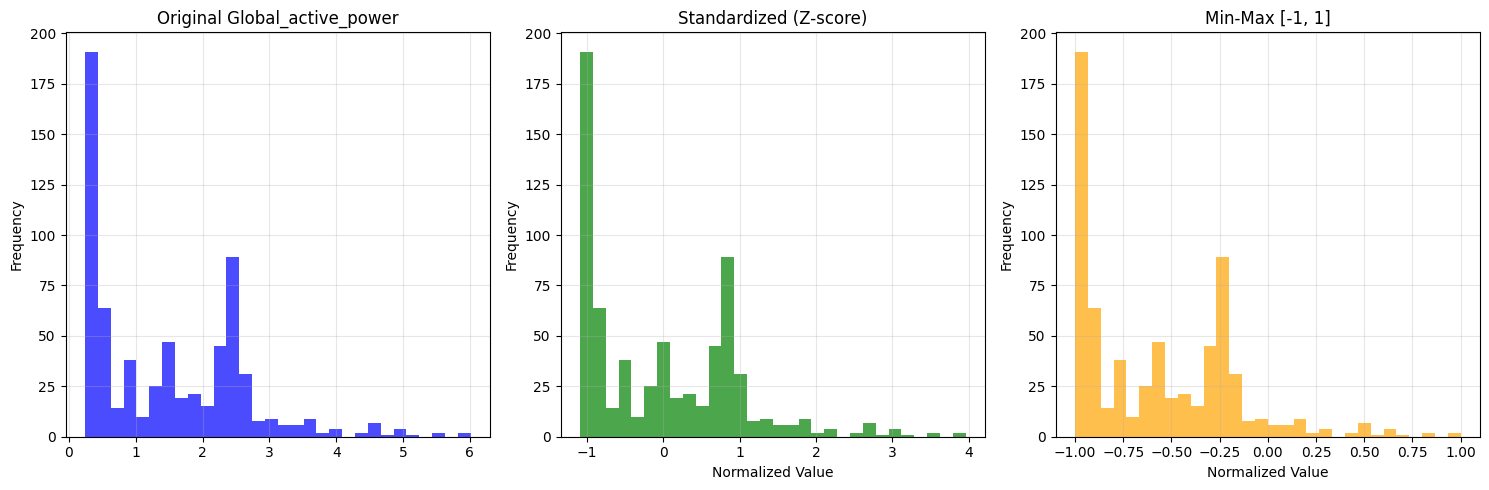


--- TESTING INVERSE TRANSFORMATION ---

standardize method:
  Global_active_power: Max difference = 8.88e-16 (should be ~0)
  Voltage: Max difference = 0.00e+00 (should be ~0)
  Global_intensity: Max difference = 3.55e-15 (should be ~0)

minmax method:
  Global_active_power: Max difference = 4.44e-16 (should be ~0)
  Voltage: Max difference = 0.00e+00 (should be ~0)
  Global_intensity: Max difference = 3.55e-15 (should be ~0)

--- TESTING SUBSET INVERSE TRANSFORMATION ---
(Simulating inverse transformation of forecasting results)

standardize method - Target variable only:
  Global_active_power (subset): Max difference = 8.88e-16

minmax method - Target variable only:
  Global_active_power (subset): Max difference = 4.44e-16


In [10]:
# Example: Demonstrate normalization methods
print("Testing normalization methods...")

# Create a sample dataset for demonstration
sample_data = df_filled['2007-01-01':'2007-01-07'].copy()

# Test both normalization methods
methods = ['standardize', 'minmax']
results = {}

for method in methods:
    print(f"\n--- {method.upper()} NORMALIZATION ---")
    
    # Select specific columns for demonstration
    target_columns = ['Global_active_power', 'Voltage', 'Global_intensity']
    
    # Apply normalization
    normalized_data, scaler_params = normalize_features(
        sample_data, 
        method=method, 
        columns=target_columns
    )
    
    # Store results
    results[method] = {
        'data': normalized_data,
        'params': scaler_params
    }
    
    # Show statistics for each normalized column
    for col in target_columns:
        if col in normalized_data.columns:
            stats = normalized_data[col].describe()
            print(f"{col}:")
            print(f"  Range: [{stats['min']:.3f}, {stats['max']:.3f}]")
            print(f"  Mean: {stats['mean']:.3f}, Std: {stats['std']:.3f}")

# Visualize normalization effects
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original data
col_to_plot = 'Global_active_power'
original_data = sample_data[col_to_plot].dropna()

axes[0].hist(original_data, bins=30, alpha=0.7, color='blue')
axes[0].set_title(f'Original {col_to_plot}')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Standardized (z-score)
standardized = results['standardize']['data'][col_to_plot].dropna()
axes[1].hist(standardized, bins=30, alpha=0.7, color='green')
axes[1].set_title(f'Standardized (Z-score)')
axes[1].set_xlabel('Normalized Value')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

# Min-Max [-1, 1]
minmax_01 = results['minmax']['data'][col_to_plot].dropna()
axes[2].hist(minmax_01, bins=30, alpha=0.7, color='orange')
axes[2].set_title(f'Min-Max [-1, 1]')
axes[2].set_xlabel('Normalized Value')
axes[2].set_ylabel('Frequency')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test inverse transformation
print("\n--- TESTING INVERSE TRANSFORMATION ---")
for method in methods:
    print(f"\n{method} method:")
    normalized_data = results[method]['data']
    scaler_params = results[method]['params']
    
    # Apply inverse transformation
    restored_data = inverse_normalize_features(normalized_data, scaler_params)
    
    # Compare original vs restored
    for col in target_columns:
        if col in sample_data.columns:
            original = sample_data[col].dropna()
            restored = restored_data[col].dropna()
            
            # Calculate difference (should be very small due to floating point precision)
            max_diff = abs(original - restored).max()
            print(f"  {col}: Max difference = {max_diff:.2e} (should be ~0)")

# Test with subset of columns (simulating forecasting results)
print("\n--- TESTING SUBSET INVERSE TRANSFORMATION ---")
print("(Simulating inverse transformation of forecasting results)")

for method in methods:
    print(f"\n{method} method - Target variable only:")
    scaler_params = results[method]['params']
    
    # Simulate forecasting result: only the target variable
    target_col = 'Global_active_power'
    if target_col in results[method]['data'].columns:
        # Create a subset with only the target variable (simulating model predictions)
        prediction_subset = results[method]['data'][[target_col]].copy()
        
        # Apply inverse transformation to subset
        restored_subset = inverse_normalize_features(prediction_subset, scaler_params, columns=[target_col])
        
        # Compare with original
        original_target = sample_data[target_col].dropna()
        restored_target = restored_subset[target_col].dropna()
        max_diff = abs(original_target - restored_target).max()
        print(f"  {target_col} (subset): Max difference = {max_diff:.2e}")

### 4. Dataset Splitting for Time Series

Time series data requires special consideration when splitting into train/validation/test sets to avoid data leakage and maintain temporal order.

#### Time Series Splitting Strategy

**Why ratios-based splitting?**

For time series data, we must preserve temporal order and avoid data leakage. The ratios method splits data chronologically:

- **Training set**: First portion of the time series (e.g., 70%)
- **Validation set**: Middle portion for model tuning (e.g., 15%) 
- **Test set**: Final portion for final evaluation (e.g., 15%)

**Key principles:**
- **Chronological order**: Earlier data for training, later data for testing
- **No shuffling**: Maintains temporal dependencies
- **No overlap**: Prevents future information leaking into past predictions
- **Representative splits**: Each set should cover sufficient time periods to capture patterns

**Common ratios:**
- **70/15/15**: Standard split for large datasets
- **80/10/10**: When you have abundant training data
- **60/20/20**: When you need more validation/test data

#### Important Considerations for Production Use

**⚠️ Tutorial Simplification Notice**

The splitting function above is simplified for tutorial purposes. In production time series forecasting, you must ensure that both validation and test sets contain **at least one full seasonality cycle** (e.g., one complete year for yearly patterns).

**Why seasonality matters:**

- **Pattern coverage**: Models need to see complete seasonal cycles to learn patterns properly
- **Robust evaluation**: Validation/test performance should reflect behavior across all seasons
- **Avoid bias**: Splitting mid-season can create artificially good/bad performance metrics
- **Real-world simulation**: Test sets should represent the full range of conditions the model will encounter

**Production recommendations:**

1. **Identify dominant seasonality**: For household energy data, this is typically yearly (heating/cooling cycles)
2. **Minimum validation period**: At least 1 full year (preferably 1.5-2 years for robust validation)
3. **Minimum test period**: At least 1 full year for reliable performance assessment
4. **Buffer periods**: Consider adding small gaps between train/val/test to simulate real deployment delays

**Example for multi-year data:**
```python
# For 4 years of data with yearly seasonality:
# Train: First 2 years (50%)
# Validation: Year 3 (25%) 
# Test: Year 4 (25%)
```

This ensures each split captures complete seasonal patterns and provides more reliable model evaluation.

In [11]:
def split_time_series_by_ratios(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Split time series data chronologically using ratio-based approach.
    
    Parameters:
    df (pd.DataFrame): Input dataframe with datetime index
    train_ratio (float): Proportion for training set (default: 0.7)
    val_ratio (float): Proportion for validation set (default: 0.15)  
    test_ratio (float): Proportion for test set (default: 0.15)
    
    Returns:
    tuple: (train_df, val_df, test_df) chronologically split dataframes
    dict: Split information with dates and sizes
    """
    # Validate ratios sum to 1.0
    total_ratio = train_ratio + val_ratio + test_ratio
    if abs(total_ratio - 1.0) > 1e-6:
        raise ValueError(f"Ratios must sum to 1.0, got {total_ratio}")
    
    # Ensure data is sorted by datetime index
    df_sorted = df.sort_index()
    total_samples = len(df_sorted)
    
    # Calculate split indices
    train_end_idx = int(total_samples * train_ratio)
    val_end_idx = int(total_samples * (train_ratio + val_ratio))
    
    # Split the data chronologically
    train_df = df_sorted.iloc[:train_end_idx].copy()
    val_df = df_sorted.iloc[train_end_idx:val_end_idx].copy()
    test_df = df_sorted.iloc[val_end_idx:].copy()
    
    # Create split information
    split_info = {
        'total_samples': total_samples,
        'train_samples': len(train_df),
        'val_samples': len(val_df), 
        'test_samples': len(test_df),
        'train_period': (train_df.index.min(), train_df.index.max()),
        'val_period': (val_df.index.min(), val_df.index.max()),
        'test_period': (test_df.index.min(), test_df.index.max()),
        'ratios_used': (train_ratio, val_ratio, test_ratio)
    }
    
    return train_df, val_df, test_df, split_info

def visualize_time_series_split(split_info, df=None):
    """
    Visualize the time series split to verify chronological order.
    
    Parameters:
    split_info (dict): Split information from split_time_series_by_ratios
    df (pd.DataFrame): Optional original dataframe for timeline visualization
    """
    print("=== TIME SERIES SPLIT SUMMARY ===")
    print(f"Total samples: {split_info['total_samples']:,}")
    print(f"Train samples: {split_info['train_samples']:,} ({split_info['train_samples']/split_info['total_samples']*100:.1f}%)")
    print(f"Val samples:   {split_info['val_samples']:,} ({split_info['val_samples']/split_info['total_samples']*100:.1f}%)")
    print(f"Test samples:  {split_info['test_samples']:,} ({split_info['test_samples']/split_info['total_samples']*100:.1f}%)")
    
    print(f"\n=== TIME PERIODS ===")
    print(f"Train period: {split_info['train_period'][0]} to {split_info['train_period'][1]}")
    print(f"Val period:   {split_info['val_period'][0]} to {split_info['val_period'][1]}")  
    print(f"Test period:  {split_info['test_period'][0]} to {split_info['test_period'][1]}")
    
    # Calculate period durations
    train_duration = split_info['train_period'][1] - split_info['train_period'][0]
    val_duration = split_info['val_period'][1] - split_info['val_period'][0]
    test_duration = split_info['test_period'][1] - split_info['test_period'][0]
    
    print(f"\n=== PERIOD DURATIONS ===")
    print(f"Train duration: {train_duration}")
    print(f"Val duration:   {val_duration}")
    print(f"Test duration:  {test_duration}")
    
    # Optional timeline visualization
    if df is not None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        
        # Plot a sample of the data to show timeline
        if 'Global_active_power' in df.columns:
            sample_data = df['Global_active_power'].dropna()
            ax.plot(sample_data.index, sample_data.values, alpha=0.7, linewidth=0.5, color='gray')
            
            # Add vertical lines to show split boundaries
            ax.axvline(split_info['train_period'][1], color='red', linestyle='--', 
                      label=f"Train/Val split", alpha=0.8)
            ax.axvline(split_info['val_period'][1], color='orange', linestyle='--', 
                      label=f"Val/Test split", alpha=0.8)
            
            # Color the background regions
            ax.axvspan(split_info['train_period'][0], split_info['train_period'][1], 
                      alpha=0.2, color='blue', label='Train')
            ax.axvspan(split_info['val_period'][0], split_info['val_period'][1], 
                      alpha=0.2, color='green', label='Validation')
            ax.axvspan(split_info['test_period'][0], split_info['test_period'][1], 
                      alpha=0.2, color='red', label='Test')
            
            ax.set_title('Time Series Split Visualization')
            ax.set_xlabel('Date')
            ax.set_ylabel('Global Active Power (kW)')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()


Demonstrating time series splitting...

=== EXAMPLE 1: Standard 70/15/15 Split ===
=== TIME SERIES SPLIT SUMMARY ===
Total samples: 136,639
Train samples: 95,647 (70.0%)
Val samples:   20,496 (15.0%)
Test samples:  20,496 (15.0%)

=== TIME PERIODS ===
Train period: 2006-12-16 17:15:00 to 2009-09-13 16:30:00
Val period:   2009-09-13 16:45:00 to 2010-04-18 18:00:00
Test period:  2010-04-18 18:15:00 to 2010-11-26 21:00:00

=== PERIOD DURATIONS ===
Train duration: 1001 days 23:15:00
Val duration:   217 days 01:15:00
Test duration:  222 days 02:45:00


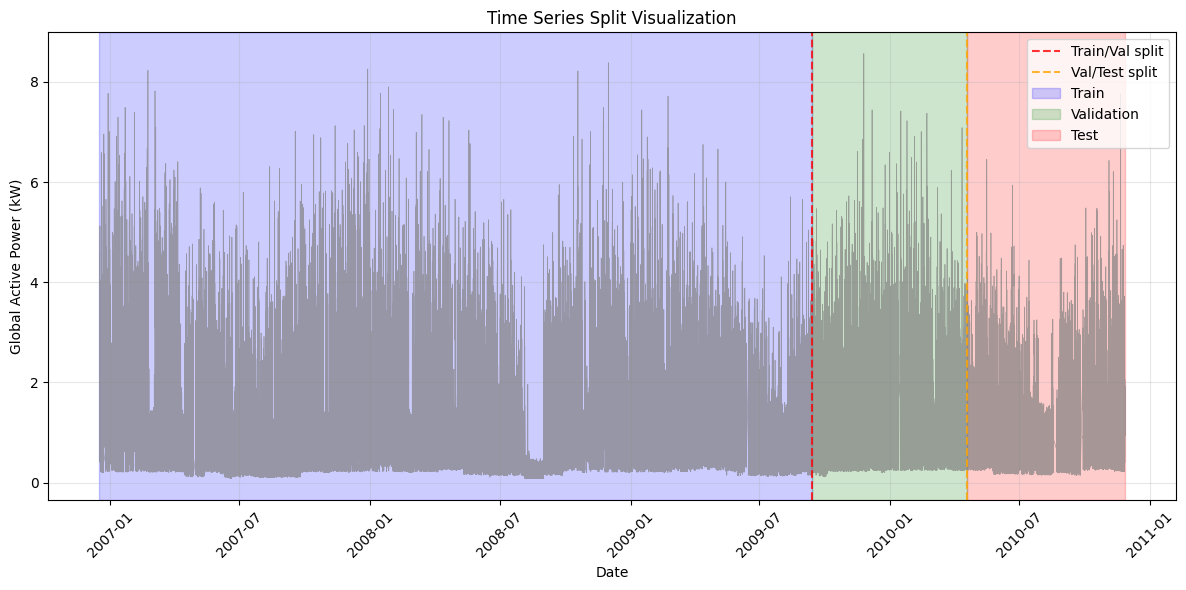

In [12]:
# Example: Demonstrate time series splitting
print("Demonstrating time series splitting...")

# Use the cleaned and filled dataset
df_for_splitting = df_filled.copy()

# Example 1: Standard 70/15/15 split
print("\n=== EXAMPLE 1: Standard 70/15/15 Split ===")
train_df, val_df, test_df, split_info = split_time_series_by_ratios(
    df_for_splitting, 
    train_ratio=0.7, 
    val_ratio=0.15, 
    test_ratio=0.15
)

# Visualize the split
visualize_time_series_split(split_info, df_for_splitting)

## Calendar Features Engineering

### 5. Holiday and Special Events

#### Understanding Dummy Variables for Calendar Events

**What are Dummy Variables?**

Dummy variables (also called indicator variables or binary variables) are binary features that take values of 0 or 1 to indicate the absence or presence of a specific condition or event. In time series forecasting, dummy variables are particularly useful for encoding calendar-based events that have discrete, well-defined boundaries.

**Key Characteristics:**
- **Binary encoding**: Each dummy variable represents a single categorical condition (0 = absent, 1 = present)
- **Mutually exclusive or overlapping**: Variables can represent non-overlapping categories (like day of week) or overlapping conditions (like holidays and weekends)
- **Interpretable**: Direct relationship between variable value and real-world event
- **Sparse representation**: Most values are 0, with 1s only during specific events

**Calendar Applications:**
- **Holidays**: `is_holiday` = 1 during national/regional holidays, 0 otherwise
- **Weekends**: `is_weekend` = 1 during Saturday/Sunday, 0 for weekdays  
- **Special events**: `is_special_event` = 1 during known irregular events
- **Interactions**: `is_weekend_holiday` = 1 when holidays occur on weekends

**Advantages over Continuous Features:**
1. **Clear interpretation**: Easy to understand which specific events affect the target
2. **Stable encoding**: No arbitrary scaling or transformation needed
3. **Model flexibility**: Different models can assign different importance to each event type
4. **Interaction modeling**: Easy to create interaction terms between different event types

**When to Use Dummy Variables vs. Fourier Features:**
- **Dummy variables**: Best for irregular, discrete events with clear start/end times (holidays, special events)
- **Fourier features**: Best for regular, periodic patterns that repeat at consistent intervals (daily/weekly/seasonal cycles)

For household energy consumption, dummy variables effectively capture the immediate impact of discrete calendar events like holidays and weekends, which often cause step-changes in consumption patterns rather than smooth periodic variations.

In [13]:
# Install holidays library if running on Colab
if in_colab:
    print("Running in Google Colab - installing holidays library...")
    %pip install holidays
else:
    print("Not running in Colab - assuming holidays library is available locally")

# Import holidays library
import holidays
print("Holidays library ready!")

Not running in Colab - assuming holidays library is available locally
Holidays library ready!


In [14]:
def add_holiday_features(df, country='France', include_holiday_names=False):
    """
    Add holiday indicators for single-day holidays.
    
    Simplified version focusing on basic holiday detection and immediate effects.
    This tutorial version demonstrates core concepts without complex multi-day patterns.
    
    Parameters:
    df (pd.DataFrame): Input dataframe with datetime index
    country (str): Country for holiday calendar
    include_holiday_names (bool): Whether to include holiday_name column for analysis
    
    Returns:
    pd.DataFrame: Dataframe with holiday features
    """
    df_holidays = df.copy()
    
    # Get country-specific holidays for all years in the dataset
    years = range(df.index.year.min(), df.index.year.max() + 1)
    country_holidays = holidays.country_holidays(country, years=years)
    
    # Create date column for holiday lookup (without time component)
    dates = df.index.date
    
    # Basic holiday indicator
    df_holidays['is_holiday'] = [date in country_holidays for date in dates]
    
    # Holiday name (for analysis, can be dropped later)
    if include_holiday_names:
        df_holidays['holiday_name'] = [
            country_holidays.get(date, '') for date in dates
        ]
    
    # Weekend indicator (useful baseline feature)
    df_holidays['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
    
    # Weekend-holiday interaction
    df_holidays['is_weekend_holiday'] = (
        df_holidays['is_holiday'] & 
        (df.index.dayofweek >= 5)  # Saturday or Sunday
    ).astype(int)
    
    return df_holidays

Creating holiday features...
Added holiday features:
['is_holiday', 'holiday_name', 'is_weekend', 'is_weekend_holiday']

Holiday Statistics for 2007:
Holiday samples (15-min intervals): 960
Weekend samples (15-min intervals): 9786
Weekend holiday samples (15-min intervals): 192

Sample holidays in 2007:
                     holiday_name
DateTime                         
2007-01-01 00:00:00  Jour de l'an
2007-01-01 00:15:00  Jour de l'an
2007-01-01 00:30:00  Jour de l'an
2007-01-01 00:45:00  Jour de l'an
2007-01-01 01:00:00  Jour de l'an
2007-01-01 01:15:00  Jour de l'an
2007-01-01 01:30:00  Jour de l'an
2007-01-01 01:45:00  Jour de l'an
2007-01-01 02:00:00  Jour de l'an
2007-01-01 02:15:00  Jour de l'an


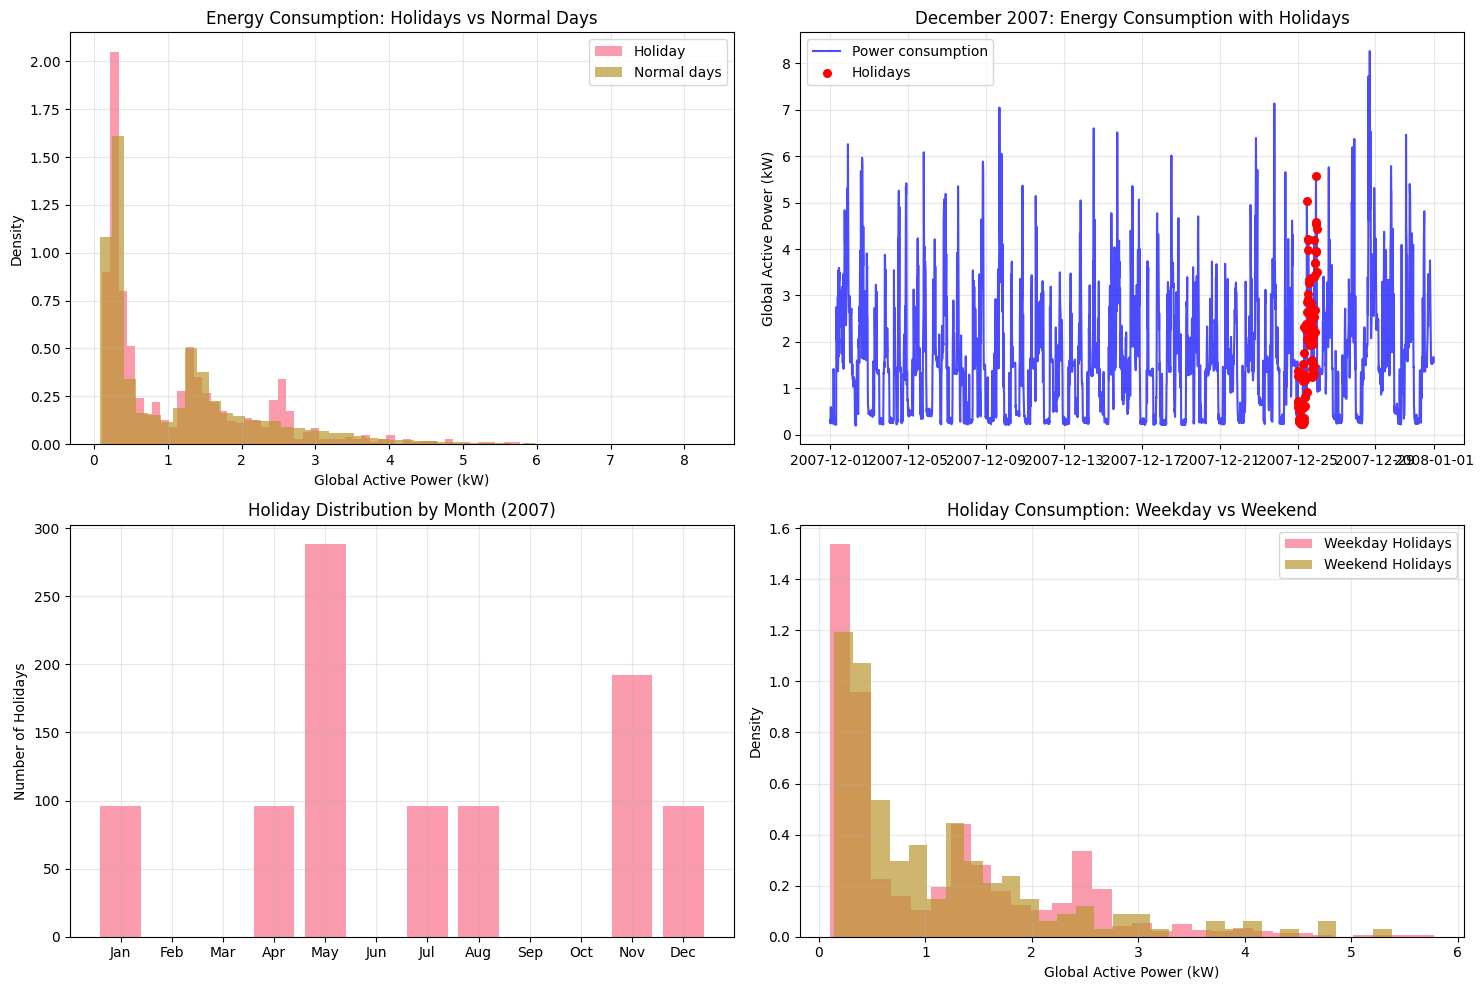


Dataset shape after adding holiday features: (34784, 11)
Original sample shape: (34784, 7)


In [15]:
# Example: Create and visualize holiday features
print("Creating holiday features...")

# Apply holiday features to a subset of data for demonstration
df_sample = df_filled['2007-01-01':'2007-12-31'].copy()  # Use one year for faster processing
df_with_holidays = add_holiday_features(df_sample, country='France', include_holiday_names=True)

print(f"Added holiday features:")
holiday_columns = [col for col in df_with_holidays.columns if col not in df_sample.columns]
print(holiday_columns)

# Show holiday statistics
print(f"\nHoliday Statistics for 2007:")
print(f"Holiday samples (15-min intervals): {df_with_holidays['is_holiday'].sum()}")
print(f"Weekend samples (15-min intervals): {df_with_holidays['is_weekend'].sum()}")
print(f"Weekend holiday samples (15-min intervals): {df_with_holidays['is_weekend_holiday'].sum()}")

# Display some specific holidays
holiday_dates = df_with_holidays[df_with_holidays['is_holiday'] == 1]
print(f"\nSample holidays in 2007:")
print(holiday_dates[['holiday_name']].head(10))

# Visualize holiday impact on energy consumption
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Holiday vs non-holiday consumption
holiday_consumption = df_with_holidays[df_with_holidays['is_holiday'] == 1]['Global_active_power']
normal_consumption = df_with_holidays[df_with_holidays['is_holiday'] == 0]['Global_active_power']

axes[0, 0].hist(holiday_consumption.dropna(), bins=50, alpha=0.7, label='Holiday', density=True)
axes[0, 0].hist(normal_consumption.dropna(), bins=50, alpha=0.7, label='Normal days', density=True)
axes[0, 0].set_title('Energy Consumption: Holidays vs Normal Days')
axes[0, 0].set_xlabel('Global Active Power (kW)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Timeline showing holidays
sample_month = df_with_holidays['2007-12-01':'2007-12-31']
axes[0, 1].plot(sample_month.index, sample_month['Global_active_power'], 'b-', alpha=0.7, label='Power consumption')
holiday_mask = sample_month['is_holiday'] == 1
axes[0, 1].scatter(sample_month.index[holiday_mask], 
                   sample_month['Global_active_power'][holiday_mask], 
                   color='red', s=30, label='Holidays', zorder=5)
axes[0, 1].set_title('December 2007: Energy Consumption with Holidays')
axes[0, 1].set_ylabel('Global Active Power (kW)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Monthly holiday distribution
monthly_holidays = df_with_holidays.groupby(df_with_holidays.index.month)['is_holiday'].sum()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[1, 0].bar(range(1, 13), monthly_holidays.values, alpha=0.7)
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_xticklabels(month_names)
axes[1, 0].set_title('Holiday Distribution by Month (2007)')
axes[1, 0].set_ylabel('Number of Holidays')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Weekend vs weekday holidays
weekend_holidays = df_with_holidays[df_with_holidays['is_weekend_holiday'] == 1]['Global_active_power']
weekday_holidays = df_with_holidays[
    (df_with_holidays['is_holiday'] == 1) & 
    (df_with_holidays['is_weekend_holiday'] == 0)
]['Global_active_power']

if len(weekend_holidays) > 0 and len(weekday_holidays) > 0:
    axes[1, 1].hist(weekday_holidays.dropna(), bins=30, alpha=0.7, label='Weekday Holidays', density=True)
    axes[1, 1].hist(weekend_holidays.dropna(), bins=30, alpha=0.7, label='Weekend Holidays', density=True)
    axes[1, 1].set_title('Holiday Consumption: Weekday vs Weekend')
    axes[1, 1].set_xlabel('Global Active Power (kW)')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'Insufficient data\nfor comparison', 
                    ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Holiday Consumption: Weekday vs Weekend')

plt.tight_layout()
plt.show()

print(f"\nDataset shape after adding holiday features: {df_with_holidays.shape}")
print(f"Original sample shape: {df_sample.shape}")

### 6. Fourier Features

#### Understanding Fourier Features

**What are Fourier Features?**

Fourier features use trigonometric functions (sine and cosine) to represent periodic patterns in time series data. They are based on the mathematical principle demonstrated by French mathematician Jean-Baptiste Fourier, who showed that **a series of sine and cosine terms of the right frequencies can approximate any periodic function**.

**Mathematical Foundation:**

If $m$ is the seasonal period (number of time steps in one complete cycle), then Fourier terms are given by:
- $x_{1,t} = \sin(2\pi t/m)$, $x_{2,t} = \cos(2\pi t/m)$  
- $x_{3,t} = \sin(4\pi t/m)$, $x_{4,t} = \cos(4\pi t/m)$
- $x_{5,t} = \sin(6\pi t/m)$, $x_{6,t} = \cos(6\pi t/m)$
- and so on...

**Understanding Seasonal Period ($m$) Values:**

The value of $m$ represents the number of time steps in one complete seasonal cycle:

- **Daily seasonality**: 
  - $m = 24$ (for hourly data)
  - $m = 96$ (for 15-minute data: $24 \text{ hours} \times 4 \text{ intervals/hour}$)
  - $m = 1440$ (for minute data: $24 \text{ hours} \times 60 \text{ minutes/hour}$)

- **Weekly seasonality**: 
  - $m = 7$ (for daily data)
  - $m = 168$ (for hourly data: $7 \text{ days} \times 24 \text{ hours/day}$)
  - $m = 672$ (for 15-minute data: $7 \text{ days} \times 96 \text{ intervals/day}$)

- **Yearly seasonality**: 
  - $m = 365$ (for daily data)
  - $m = 52$ (for weekly data)
  - $m = 8760$ (for hourly data: $365 \text{ days} \times 24 \text{ hours/day}$)

**Example for Our 15-minute Energy Data:**
- **Daily cycle**: $m = 96$ (one day = 96 fifteen-minute intervals)
- **Weekly cycle**: $m = 672$ (one week = $7 \times 96 = 672$ fifteen-minute intervals)
- **Yearly cycle**: $m = 35,040$ (one year $\approx 365 \times 96 = 35,040$ fifteen-minute intervals)

**Key Advantages:**

1. **Efficient representation**: With Fourier terms, we often need **fewer predictors than with dummy variables**, especially when $m$ is large (e.g., weekly data where $m \approx 52$)

2. **Harmonic modeling**: The successive Fourier terms represent **harmonics** of the fundamental frequency, allowing capture of complex seasonal patterns

3. **Flexibility**: For short seasonal periods (e.g., quarterly data), Fourier terms give results **identical to seasonal dummy variables** when using the maximum number of terms

4. **Computational efficiency**: Particularly useful for high-frequency seasonality where traditional dummy variables would create too many features

**Harmonics Explained:**
- **$k=1$**: Fundamental frequency (basic seasonal cycle)
- **$k=2$**: Second harmonic (captures sub-patterns within the main cycle)  
- **$k=3$**: Third harmonic (captures even finer periodic details)

**Real-world Application:**
For household energy consumption, Fourier features can capture:
- Morning/evening usage peaks (daily patterns)
- Weekday vs weekend differences (weekly sub-patterns)
- Seasonal heating/cooling variations (yearly patterns)

**Reference:** This approach is extensively covered in [Section 7.4 of "Forecasting: Principles and Practice"](https://otexts.com/fpppy/nbs/07-regression.html#fourier-series), which demonstrates how Fourier series provide a powerful alternative to seasonal dummy variables for regression-based forecasting models.

In [16]:
def create_fourier_features(dataset, num_fourier_terms=3):
    """
    Create Fourier terms for daily and yearly cycles.
    
    Fourier features capture periodic patterns more effectively than simple
    cyclical encoding by using multiple harmonics.
    
    Parameters:
    dataset (pd.DataFrame): Input dataframe with datetime index
    num_fourier_terms (int): Number of Fourier terms to generate
    
    Returns:
    pd.DataFrame: Dataframe with added Fourier features
    list: List of column names that were added
    """
    dataset = dataset.copy()
    used_columns = []
    
    # Convert datetime index to timestamp in seconds
    timestamp_s = dataset.index.astype('int64') // 10**9
    
    # Define time periods in seconds
    day = 24*60*60
    year = (365.2425)*day

    for k in range(1, num_fourier_terms + 1):
        # Daily Fourier terms
        prefix = 'Day'
        col_name = prefix + f" sin{k}"
        dataset[col_name] = np.sin(timestamp_s * (2 * k * np.pi / day))
        used_columns.append(col_name)

        col_name = prefix + f" cos{k}"
        dataset[col_name] = np.cos(timestamp_s * (2 * k * np.pi / day))
        used_columns.append(col_name)

        # Yearly Fourier terms
        prefix = 'Year'
        col_name = prefix + f" sin{k}"
        dataset[col_name] = np.sin(timestamp_s * (2 * k * np.pi / year))
        used_columns.append(col_name)

        col_name = prefix + f" cos{k}"
        dataset[col_name] = np.cos(timestamp_s * (2 * k * np.pi / year))
        used_columns.append(col_name)
    
    return dataset, used_columns

Creating Fourier features...
Added 12 Fourier features:
['Day sin1', 'Day cos1', 'Year sin1', 'Year cos1', 'Day sin2', 'Day cos2', 'Year sin2', 'Year cos2', 'Day sin3', 'Day cos3', 'Year sin3', 'Year cos3']


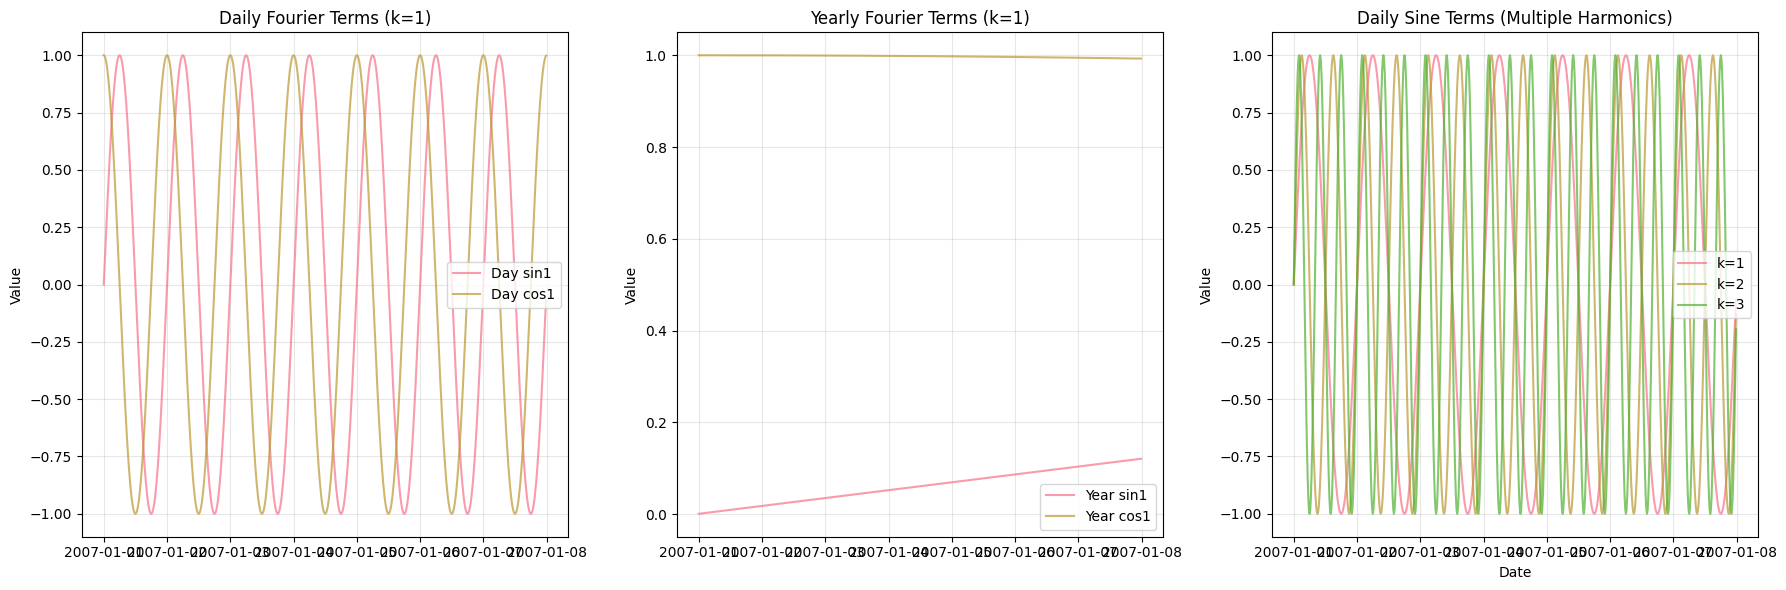

In [17]:
# Example: Create and visualize Fourier features
print("Creating Fourier features...")

# Create Fourier features
df_fourier, fourier_columns = create_fourier_features(df_filled, num_fourier_terms=3)

print(f"Added {len(fourier_columns)} Fourier features:")
print(fourier_columns)

# Plot the Fourier features
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Sample a week for visualization
sample_start = '2007-01-01'
sample_end = '2007-01-07'
df_sample = df_fourier[sample_start:sample_end]

# Plot daily Fourier terms
axes[0].plot(df_sample.index, df_sample['Day sin1'], label='Day sin1', alpha=0.7)
axes[0].plot(df_sample.index, df_sample['Day cos1'], label='Day cos1', alpha=0.7)
axes[0].set_title('Daily Fourier Terms (k=1)')
axes[0].set_ylabel('Value')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot yearly Fourier terms (zoomed to see variation)
axes[1].plot(df_sample.index, df_sample['Year sin1'], label='Year sin1', alpha=0.7)
axes[1].plot(df_sample.index, df_sample['Year cos1'], label='Year cos1', alpha=0.7)
axes[1].set_title('Yearly Fourier Terms (k=1)')
axes[1].set_ylabel('Value')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot multiple daily harmonics
axes[2].plot(df_sample.index, df_sample['Day sin1'], label='k=1', alpha=0.7)
axes[2].plot(df_sample.index, df_sample['Day sin2'], label='k=2', alpha=0.7)
axes[2].plot(df_sample.index, df_sample['Day sin3'], label='k=3', alpha=0.7)
axes[2].set_title('Daily Sine Terms (Multiple Harmonics)')
axes[2].set_ylabel('Value')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Windowing Techniques

### 7. Sliding Window Creation

#### Understanding Sliding Windows for Time Series

**What are Sliding Windows?**

Sliding windows transform a time series into a supervised learning problem by creating **input-output pairs** from consecutive observations. This technique is essential for training neural networks on time series data because it converts sequential data into the format expected by supervised learning algorithms.

**The Transformation Process:**

Given a time series: `[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]`

With `window_size=3` and `forecast_horizon=2`, we create:
```
Input (X)     →  Output (y)
[1, 2, 3]     →     [4, 5]
[2, 3, 4]     →     [5, 6]  
[3, 4, 5]     →     [6, 7]
[4, 5, 6]     →     [7, 8]
[5, 6, 7]     →     [8, 9]
[6, 7, 8]     →     [9, 10]
```

**Multivariate Time Series:**

For datasets like our household energy consumption with multiple features (power, voltage, sub-metering, holidays, etc.), windowing works across all variables simultaneously:

```
Time Step  | Power | Voltage | Holiday | Fourier_sin1
    t-2    |  2.1  |   240   |    0    |    0.5
    t-1    |  1.8  |   239   |    0    |    0.3
    t      |  2.3  |   241   |    1    |    0.1
```

With `window_size=3`, one window becomes:
- **Input (X)**: 3×4 matrix containing 3 time steps of 4 features
- **Target (y)**: Could be just the power values for next 2 steps, or all features

This allows models to learn relationships **between different variables** (e.g., how holidays affect power consumption) and **temporal patterns within each variable**.

**Key Parameters:**

- **Window Size**: Number of previous time steps to use as input features
- **Forecast Horizon**: Number of future time steps to predict
- **Step Size**: How many positions to advance between windows (usually 1 for maximum data utilization)

**Why Neural Networks Need This:**

1. **Supervised Learning Format**: Neural networks require (X, y) pairs for training
2. **Fixed Input Size**: Networks expect consistent input dimensions across all samples
3. **Pattern Recognition**: Windows allow networks to learn temporal patterns and dependencies
4. **Batch Processing**: Multiple windows can be processed simultaneously during training

**Multi-step and Multi-variate Extensions:**

- **Multi-step forecasting**: `forecast_horizon > 1` to predict multiple future points
- **Multi-variate**: Include multiple time series features in each window (like our energy dataset)
- **Sequence-to-sequence**: Both input and output can be sequences
- **Feature selection**: Choose which variables to predict (e.g., only forecast power consumption using all available features as inputs)

**Practical Considerations:**

- **Window size selection**: Balance between capturing patterns and computational efficiency
- **Data loss explanation**: With `window_size=3`, we cannot create windows for the first 2 data points because they don't have enough previous history. For example, data point 1 `[1]` has no previous values, and data point 2 `[2]` only has 1 previous value `[1]`, but we need 3 values for our window. So we "lose" the first `window_size-1 = 2` data points as potential targets.
- **Temporal ordering**: Maintain chronological order to avoid data leakage
- **Overlap**: Adjacent windows share most observations, creating implicit regularization
- **Feature engineering**: Combine engineered features (holidays, Fourier) with raw measurements for richer input representations

In [64]:
# Import TensorFlow and Keras utilities for time series
import tensorflow as tf
import keras

def create_sliding_windows(data, window_size, forecast_horizon=1, step_size=1, 
                         batch_size=32, shuffle=False, target_columns=None):
    """
    Create sliding windows using Keras timeseries utilities.
    
    This is the recommended approach for Keras/TensorFlow time series workflows.
    Uses keras.utils.timeseries_dataset_from_array for optimal performance.
    
    Parameters:
    data (array-like): Time series data
    window_size (int): Number of time steps in input window
    forecast_horizon (int): Number of time steps to predict
    step_size (int): Step size between windows (sampling_rate)
    batch_size (int): Batch size for the dataset
    shuffle (bool): Whether to shuffle the windows. IMPORTANT: This shuffles the 
                   windows AFTER they are created as (input, target) pairs, so the 
                   temporal order within each window is preserved. Each neural network 
                   example maintains its correct time sequence, but the order in which 
                   these examples are presented during training is randomized. This is 
                   crucial for training stability while preserving time series structure.
    target_columns (list or None): Column indices to predict. If None, predicts all columns.
                                  For univariate forecasting with exogenous variables,
                                  specify only the target column index (e.g., [0])
    
    Returns:
    tf.data.Dataset: Keras dataset ready for model training
    """
    # Convert to numpy array if needed
    if hasattr(data, 'values'):
        data = data.values
    data = np.array(data)
    
    # Ensure data is float32 for TensorFlow
    data = data.astype(np.float32)
    
    # Handle 1D data (ensure it's 2D)
    if data.ndim == 1:
        data = data.reshape(-1, 1)
    
    # Create the windowed dataset using Keras utility
    # We'll create the full sequences and split them later
    dataset = keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,  # We'll create targets from the same data
        sequence_length=window_size + forecast_horizon,
        sequence_stride=step_size,
        shuffle=shuffle,
        batch_size=batch_size
    )
    
    # Split each sequence into input (X) and target (y)
    def split_window(sequence):
        # Input: first 'window_size' steps, all features
        inputs = sequence[:, :window_size]  # Shape: (batch, window_size, all_features)
        
        # Target: next 'forecast_horizon' steps
        targets_full = sequence[:, window_size:]  # Shape: (batch, forecast_horizon, all_features)
        
        # Apply target column selection if specified
        if target_columns is not None:
            # Use Keras ops for backend-agnostic indexing
            targets = keras.ops.take(targets_full, target_columns, axis=-1) # Shape: (batch, forecast_horizon, len(target_columns))
        else:
            targets = targets_full
        
        return inputs, targets
    
    # Apply the windowing split
    dataset = dataset.map(split_window, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Optimize dataset performance
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [65]:
# Example: Basic single-step windowing with Keras utilities
print("=== KERAS TIME SERIES WINDOWING DEMONSTRATION ===")
print("Original series: 1 to 100")

# Create a simple series from 1 to 100
simple_series = np.arange(1, 101, dtype=np.float32)
print(f"Series shape: {simple_series.shape}")
print(f"First 10 values: {simple_series[:10]}")
print(f"Last 10 values: {simple_series[-10:]}")

# Parameters for windowing
WINDOW_SIZE = 5
FORECAST_HORIZON = 1
STEP_SIZE = 1
BATCH_SIZE = 8

print(f"\nWindowing parameters:")
print(f"- Window size: {WINDOW_SIZE}")
print(f"- Forecast horizon: {FORECAST_HORIZON}")
print(f"- Step size: {STEP_SIZE}")
print(f"- Batch size: {BATCH_SIZE}")

print(f"\n=== USING KERAS TIMESERIES_DATASET_FROM_ARRAY ===")

# Create windowed dataset using Keras utilities
keras_dataset = create_sliding_windows(
    simple_series,
    window_size=WINDOW_SIZE,
    forecast_horizon=FORECAST_HORIZON,
    step_size=STEP_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False  # Keep temporal order for time series
)

print("Keras dataset created successfully!")

# Examine dataset structure
for batch_X, batch_y in keras_dataset.take(1):
    print(f"\nDataset structure:")
    print(f"- Input batch shape: {batch_X.shape}")
    print(f"- Target batch shape: {batch_y.shape}")
    print(f"- Input dtype: {batch_X.dtype}")
    print(f"- Target dtype: {batch_y.dtype}")
    break

# Show first few batches
print(f"\n=== FIRST 3 BATCHES ===")
for batch_idx, (batch_X, batch_y) in enumerate(keras_dataset.take(3)):
    print(f"\nBatch {batch_idx + 1}:")
    print(f"  Input shape: {batch_X.shape}")
    print(f"  Target shape: {batch_y.shape}")
    
    # Show first sample in each batch
    first_input = batch_X[0].numpy().flatten()
    first_target = batch_y[0].numpy()
    if first_target.ndim == 0:  # Single value
        first_target = float(first_target)
    else:
        first_target = first_target.flatten()
    
    print(f"  First sample: X={first_input} → y={first_target}")

# Count total windows
total_windows = sum(1 for _ in keras_dataset.unbatch())
print(f"\nTotal windows created: {total_windows}")

=== KERAS TIME SERIES WINDOWING DEMONSTRATION ===
Original series: 1 to 100
Series shape: (100,)
First 10 values: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Last 10 values: [ 91.  92.  93.  94.  95.  96.  97.  98.  99. 100.]

Windowing parameters:
- Window size: 5
- Forecast horizon: 1
- Step size: 1
- Batch size: 8

=== USING KERAS TIMESERIES_DATASET_FROM_ARRAY ===
Keras dataset created successfully!

Dataset structure:
- Input batch shape: (8, 5, 1)
- Target batch shape: (8, 1, 1)
- Input dtype: <dtype: 'float32'>
- Target dtype: <dtype: 'float32'>

=== FIRST 3 BATCHES ===

Batch 1:
  Input shape: (8, 5, 1)
  Target shape: (8, 1, 1)
  First sample: X=[1. 2. 3. 4. 5.] → y=[6.]

Batch 2:
  Input shape: (8, 5, 1)
  Target shape: (8, 1, 1)
  First sample: X=[ 9. 10. 11. 12. 13.] → y=[14.]

Batch 3:
  Input shape: (8, 5, 1)
  Target shape: (8, 1, 1)
  First sample: X=[17. 18. 19. 20. 21.] → y=[22.]

Total windows created: 95

Total windows created: 95


In [66]:
# Example: Multi-step forecasting
print("=== WINDOWING FOR MULTI-STEP FORECASTING ===")
FORECAST_HORIZON_MULTI = 3

keras_dataset_multi = create_sliding_windows(
    simple_series,
    window_size=WINDOW_SIZE,
    forecast_horizon=FORECAST_HORIZON_MULTI,
    step_size=STEP_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"Multi-step forecasting parameters:")
print(f"- Window size: {WINDOW_SIZE}")
print(f"- Forecast horizon: {FORECAST_HORIZON_MULTI}")
print(f"- Step size: {STEP_SIZE}")

for batch_X, batch_y in keras_dataset_multi.take(1):
    print(f"\nMulti-step dataset structure:")
    print(f"- Input shape: {batch_X.shape}")
    print(f"- Target shape: {batch_y.shape}")
    
    # Show first sample
    first_input = batch_X[0].numpy().flatten()
    first_target = batch_y[0].numpy().flatten()
    print(f"- First sample: X={first_input} → y={first_target}")
    break

# Show first few multi-step windows
print(f"\nFirst 3 multi-step windows:")
X_multi_list, y_multi_list = [], []
for batch_X, batch_y in keras_dataset_multi.take(2):  # Take 2 batches to get more samples
    X_multi_list.append(batch_X.numpy())
    y_multi_list.append(batch_y.numpy())

X_multi = np.concatenate(X_multi_list, axis=0)
y_multi = np.concatenate(y_multi_list, axis=0)

for i in range(min(3, len(X_multi))):
    input_seq = X_multi[i].flatten()
    target_seq = y_multi[i].flatten()
    print(f"Window {i+1}: X={input_seq} → y={target_seq}")

=== WINDOWING FOR MULTI-STEP FORECASTING ===
Multi-step forecasting parameters:
- Window size: 5
- Forecast horizon: 3
- Step size: 1

Multi-step dataset structure:
- Input shape: (8, 5, 1)
- Target shape: (8, 3, 1)
- First sample: X=[1. 2. 3. 4. 5.] → y=[6. 7. 8.]

First 3 multi-step windows:
Window 1: X=[1. 2. 3. 4. 5.] → y=[6. 7. 8.]
Window 2: X=[2. 3. 4. 5. 6.] → y=[7. 8. 9.]
Window 3: X=[3. 4. 5. 6. 7.] → y=[ 8.  9. 10.]


### Multivariate Time Series Windowing

**Note:** This demonstrates **univariate forecasting** (1 target variable) with **exogenous variables**. We predict only the first variable while using additional variables as input features to improve forecasting accuracy.

This is a common approach in real-world forecasting where:
- **Target variable**: The main variable we want to predict
- **Exogenous variables**: Additional contextual variables that help improve predictions but are not themselves being forecasted

For example, when forecasting energy consumption, we might use weather variables, calendar features, or economic indicators as exogenous inputs.

#### Important Note: Past vs Future Exogenous Variables

In the interest of time, we only demonstrated the use of **past exogenous variables** (historical values available in the input window). However, in practice, you might also have **future exogenous variables** - variables whose values are known or can be calculated for future time steps (e.g., weather forecasts, scheduled events, calendar features).

If we wanted to include future exogenous variables, we would need to modify our windowing function to return inputs as tuples of `(observations, past_exogenous, future_exogenous)` because:

- **Past exogenous**: Shape `(batch, window_size, num_past_features)` - same length as historical observations
- **Future exogenous**: Shape `(batch, forecast_horizon, num_future_features)` - same length as prediction horizon
- **Different time dimensions**: Past and future exogenous variables have different temporal lengths, requiring separate handling

This tuple structure allows models to properly handle the different temporal contexts of various input features.

In [67]:
# Example: Multivariate time series windowing (univariate forecasting with exogenous variables)

# Create multivariate data: two variables
variable1 = np.arange(1, 101, dtype=np.float32)        # 1 to 100 (TARGET variable)
variable2 = np.arange(1000, 1100, dtype=np.float32)    # 1000 to 1100 (EXOGENOUS variable)

# Combine into multivariate array (samples, features)
multivariate_data = np.column_stack([variable1, variable2])

print(f"Multivariate data shape: {multivariate_data.shape}")
print(f"Target variable (first 5): {variable1[:5]}")
print(f"Exogenous variable (first 5): {variable2[:5]}")
print(f"Combined data (first 5 rows):")
print(multivariate_data[:5])

# Create windowed dataset for multivariate data
WINDOW_SIZE_MV = 4
FORECAST_HORIZON_MV = 2
BATCH_SIZE_MV = 6

print(f"\nMultivariate windowing parameters:")
print(f"- Window size: {WINDOW_SIZE_MV}")
print(f"- Forecast horizon: {FORECAST_HORIZON_MV}")
print(f"- Number of input features: {multivariate_data.shape[1]}")
print(f"- Target: Variable 1 only (univariate forecasting)")

# target_columns=[0] means we only predict the first column (variable1)
keras_dataset_multivariate = create_sliding_windows(
    multivariate_data,
    window_size=WINDOW_SIZE_MV,
    forecast_horizon=FORECAST_HORIZON_MV,
    step_size=1,
    batch_size=BATCH_SIZE_MV,
    shuffle=False,
    target_columns=[0]  # Only predict the first variable (target)
)

# Examine multivariate dataset structure
for batch_X, batch_y in keras_dataset_multivariate.take(1):
    print(f"\nMultivariate dataset structure:")
    print(f"- Input batch shape: {batch_X.shape}")  # (batch, window_size, all_features)
    print(f"- Target batch shape: {batch_y.shape}")  # (batch, forecast_horizon, target_features)
    print(f"- Input dtype: {batch_X.dtype}")
    print(f"- Target dtype: {batch_y.dtype}")
    
    # Show first sample
    first_input_mv = batch_X[0].numpy()  # Shape: (window_size, all_features)
    first_target_mv = batch_y[0].numpy()  # Shape: (forecast_horizon, target_features)
    
    print(f"\nFirst multivariate sample:")
    print(f"Input window shape: {first_input_mv.shape}")
    print(f"Target shape: {first_target_mv.shape}")
    
    print(f"\nInput window (4 time steps × 2 features):")
    for t in range(first_input_mv.shape[0]):
        var1_val = first_input_mv[t, 0]  # Target variable
        var2_val = first_input_mv[t, 1]  # Exogenous variable
        print(f"  Time {t+1}: [Target={var1_val:.0f}, Exogenous={var2_val:.0f}]")
    
    print(f"\nTarget (2 future steps of target variable only):")
    for step in range(first_target_mv.shape[0]):
        target_val = first_target_mv[step, 0]
        print(f"  Step {step+1}: Target={target_val:.0f}")
    break

# Show multiple multivariate windows
print(f"\n=== FIRST 3 MULTIVARIATE WINDOWS ===")
X_mv_list, y_mv_list = [], []
for batch_X, batch_y in keras_dataset_multivariate.take(2):  # Take 2 batches
    X_mv_list.append(batch_X.numpy())
    y_mv_list.append(batch_y.numpy())

X_mv = np.concatenate(X_mv_list, axis=0)
y_mv = np.concatenate(y_mv_list, axis=0)

for i in range(min(3, len(X_mv))):
    print(f"\nWindow {i+1}:")
    input_window = X_mv[i]  # Shape: (window_size, all_features)
    target_values = y_mv[i]  # Shape: (forecast_horizon, target_features)
    
    print(f"  Input window:")
    for t in range(input_window.shape[0]):
        var1_val = input_window[t, 0]  # Target variable
        var2_val = input_window[t, 1]  # Exogenous variable
        print(f"    Time {t+1}: [Target={var1_val:.0f}, Exogenous={var2_val:.0f}]")
    
    print(f"  Target (2 future steps of target variable):")
    for step in range(target_values.shape[0]):
        target_val = target_values[step, 0]
        print(f"    Step {step+1}: Target={target_val:.0f}")

Multivariate data shape: (100, 2)
Target variable (first 5): [1. 2. 3. 4. 5.]
Exogenous variable (first 5): [1000. 1001. 1002. 1003. 1004.]
Combined data (first 5 rows):
[[1.000e+00 1.000e+03]
 [2.000e+00 1.001e+03]
 [3.000e+00 1.002e+03]
 [4.000e+00 1.003e+03]
 [5.000e+00 1.004e+03]]

Multivariate windowing parameters:
- Window size: 4
- Forecast horizon: 2
- Number of input features: 2
- Target: Variable 1 only (univariate forecasting)

Multivariate dataset structure:
- Input batch shape: (6, 4, 2)
- Target batch shape: (6, 2, 1)
- Input dtype: <dtype: 'float32'>
- Target dtype: <dtype: 'float32'>

First multivariate sample:
Input window shape: (4, 2)
Target shape: (2, 1)

Input window (4 time steps × 2 features):
  Time 1: [Target=1, Exogenous=1000]
  Time 2: [Target=2, Exogenous=1001]
  Time 3: [Target=3, Exogenous=1002]
  Time 4: [Target=4, Exogenous=1003]

Target (2 future steps of target variable only):
  Step 1: Target=5
  Step 2: Target=6

=== FIRST 3 MULTIVARIATE WINDOWS ===


### Understanding the Shuffle Parameter in Time Series Windowing

The `shuffle` parameter in our windowing function deserves special attention because it works differently than you might expect:

#### How Shuffling Works:
1. **Windows are created first**: The function creates all the sliding windows as (input, target) pairs
2. **Then shuffling occurs**: Only AFTER windowing, the complete windows are shuffled
3. **Time order within windows is preserved**: Each individual window maintains its correct temporal sequence

#### Example of Shuffling Behavior:
```
Original time series: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Window size: 3, Forecast horizon: 1

Created windows:
Window 1: Input=[1,2,3] → Target=[4]
Window 2: Input=[2,3,4] → Target=[5]  
Window 3: Input=[3,4,5] → Target=[6]
Window 4: Input=[4,5,6] → Target=[7]

With shuffle=True, training might see:
Epoch 1: Window 3, Window 1, Window 4, Window 2
Epoch 2: Window 2, Window 4, Window 1, Window 3
```

#### Why This Matters:
- ✅ **Preserves temporal structure**: Each neural network example shows correct time progression
- ✅ **Improves training**: Randomized presentation prevents overfitting to temporal patterns in training order
- ✅ **Maintains causality**: Past values still precede future values within each window

#### When to Use Shuffle:
- **Training**: Usually `shuffle=True` for better gradient updates
- **Validation/Testing**: Usually `shuffle=False` to maintain evaluation consistency
- **Time series analysis**: `shuffle=False` when you need to analyze sequential predictions

In [71]:
# Practical demonstration of shuffling behavior
print("=== SHUFFLING BEHAVIOR DEMONSTRATION ===")

# Create a simple time series for demonstration
demo_series = np.arange(1, 11, dtype=np.float32)  # [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
print(f"Original series: {demo_series}")

# Create windows with shuffle=False (preserve order)
print(f"\n--- With shuffle=False (preserves window order) ---")
dataset_no_shuffle = create_sliding_windows(
    demo_series, 
    window_size=3, 
    forecast_horizon=1, 
    batch_size=10,  # Large batch to see all windows at once
    shuffle=False
)

# Show the windows in order
for batch_X, batch_y in dataset_no_shuffle.take(1):
    print("Windows in original order:")
    for i in range(batch_X.shape[0]):
        input_window = batch_X[i].numpy().flatten()
        target_val = batch_y[i].numpy()
        print(f"  Window {i+1}: Input={input_window} → Target={target_val}")

# Create windows with shuffle=True (randomize order)
print(f"\n--- With shuffle=True (randomizes window presentation) ---")
dataset_shuffle = create_sliding_windows(
    demo_series, 
    window_size=3, 
    forecast_horizon=1, 
    batch_size=10,  # Large batch to see all windows at once
    shuffle=True,
    step_size=1
)

# Show the windows in shuffled order
for batch_X, batch_y in dataset_shuffle.take(1):
    print("Windows in shuffled order:")
    for i in range(batch_X.shape[0]):
        input_window = batch_X[i].numpy().flatten()
        target_val = batch_y[i].numpy()
        print(f"  Window {i+1}: Input={input_window} → Target={target_val}")

print(f"\n✅ Notice: Each window maintains its temporal order (1→2→3→4), but the")
print(f"   presentation order of complete windows is randomized when shuffle=True")

=== SHUFFLING BEHAVIOR DEMONSTRATION ===
Original series: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]

--- With shuffle=False (preserves window order) ---
Windows in original order:
  Window 1: Input=[1. 2. 3.] → Target=[[4.]]
  Window 2: Input=[2. 3. 4.] → Target=[[5.]]
  Window 3: Input=[3. 4. 5.] → Target=[[6.]]
  Window 4: Input=[4. 5. 6.] → Target=[[7.]]
  Window 5: Input=[5. 6. 7.] → Target=[[8.]]
  Window 6: Input=[6. 7. 8.] → Target=[[9.]]
  Window 7: Input=[7. 8. 9.] → Target=[[10.]]

--- With shuffle=True (randomizes window presentation) ---
Windows in shuffled order:
  Window 1: Input=[7. 8. 9.] → Target=[[10.]]
  Window 2: Input=[1. 2. 3.] → Target=[[4.]]
  Window 3: Input=[4. 5. 6.] → Target=[[7.]]
  Window 4: Input=[5. 6. 7.] → Target=[[8.]]
  Window 5: Input=[2. 3. 4.] → Target=[[5.]]
  Window 6: Input=[3. 4. 5.] → Target=[[6.]]
  Window 7: Input=[6. 7. 8.] → Target=[[9.]]

✅ Notice: Each window maintains its temporal order (1→2→3→4), but the
   presentation order of compl

## Conclusion

This notebook has provided a comprehensive introduction to time series preprocessing for deep learning applications. We covered:

### Key Preprocessing Techniques:
1. **Data Cleaning & Exploration**: Understanding the structure and quality of household power consumption data
2. **Missing Value Handling**: Forward-fill and interpolation strategies for time series continuity
3. **Normalization**: Standardization and Min-Max scaling with proper inverse transformation capabilities
4. **Temporal Splitting**: Chronological train/validation/test splits that respect time dependencies
5. **Cyclical Feature Engineering**: Hour-of-day, day-of-week, and seasonal patterns using sine/cosine encoding
6. **Holiday Features**: Binary indicators for special temporal events using the holidays package
7. **Windowing Techniques**: Sliding window creation for supervised learning with Keras utilities

### Advanced Windowing Capabilities:
- **Single-step and Multi-step Forecasting**: Flexible forecast horizons for different prediction scenarios
- **Univariate Forecasting with Exogenous Variables**: Using additional features while predicting only target variables
- **Backend-Compatible Implementation**: Keras 3 operations for multi-backend support (TensorFlow, JAX, PyTorch)
- **Proper Tensor Shape Management**: Maintaining consistent dimensions for neural network training
- **Shuffling Behavior**: Understanding window-level vs sequence-level randomization for training stability

### Production Considerations:
- **Scalable Preprocessing**: TensorFlow Dataset pipelines optimized for large-scale training
- **Parameter Persistence**: Saving normalization parameters for consistent test-time preprocessing  
- **Memory Efficiency**: Batched processing and dataset prefetching for optimal performance
- **Time Series Integrity**: Preserving temporal order within windows while enabling training randomization

The preprocessing pipeline established here provides a solid foundation for building robust time series forecasting models with deep learning frameworks. The windowing function with `target_columns` parameter enables flexible forecasting scenarios commonly encountered in energy consumption prediction and other time series applications.

**Next Steps**: These preprocessed datasets are ready for neural network training with architectures like LSTMs, GRUs, Transformers, or CNNs for time series forecasting tasks.